In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train = pd.read_csv('train.csv')

# Additional BBC dataset from Kaggle https://www.kaggle.com/code/yufengdev/bbc-text-categorization/data
ext_orig = pd.read_csv('bbc-text.csv')
ext_orig = ext_orig[ext_orig['category'] == 'politics']
ext_orig['dataset-origin'] = 'original'
ext_orig['label'] = 0

ext_orig = ext_orig.drop(columns=['category'])
train = pd.concat([train, ext_orig])
train['no_words'] = train['text'].apply(lambda x: len(x.split()))
train = train.reset_index(drop=True)

Text(0.5, 1.0, 'Word count distribution for Phi2')

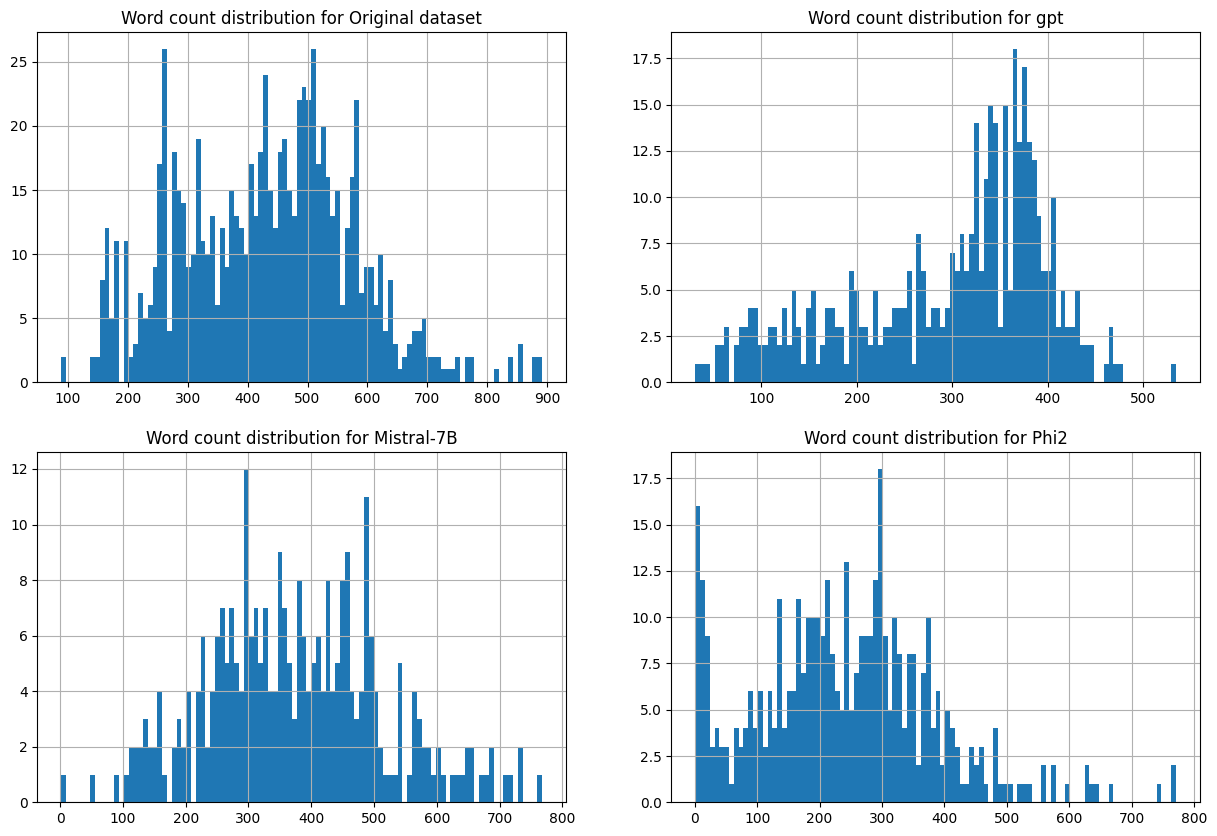

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
train[(train['dataset-origin'] == 'original') & (train['no_words'] < 900)]['no_words'].hist(bins=100)
plt.title('Word count distribution for Original dataset')

plt.subplot(2,2,2)
train[train['dataset-origin'] == 'gpt']['no_words'].hist(bins=100)
plt.title('Word count distribution for gpt')

plt.subplot(2,2,3)
train[train['dataset-origin'] == 'mistral7b']['no_words'].hist(bins=100)
plt.title('Word count distribution for Mistral-7B')

plt.subplot(2,2,4)
train[train['dataset-origin'] == 'phi2']['no_words'].hist(bins=100)
plt.title('Word count distribution for Phi2')

In [4]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [5]:
X = train['text']
y = train['label']
train['kfold'] = -1
train['text'] = train['text'].apply(lambda x: x.strip())

### Perform K-fold split

In [6]:
# Initialize StratifiedKFold to split the data into 5 folds
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

fold_no = 0
# Split dataset into 5 different folds with stratification
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train.loc[test_index, 'kfold'] = fold_no
    fold_no += 1

In [7]:
train['dataset-origin'].value_counts()

original     834
phi2         417
gpt          417
mistral7b    293
Name: dataset-origin, dtype: int64

### Train Customer BPE Tokenizer

In [8]:
from tqdm import tqdm
from transformers import PreTrainedTokenizerFast
from tokenizers import (
    trainers,
    models,
    normalizers,
    pre_tokenizers,
    Tokenizer,
)
from datasets import Dataset

In [9]:
LOWERCASE = False
VOCAB_SIZE = 30000

# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
# Creating huggingface dataset object
dataset = Dataset.from_pandas(train[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1961/1961 [00:01<00:00, 1178.84it/s]


### Fit TFIDF on the BPE tokens to generate a vocabulary of ngram_range=(1,2)

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, sublinear_tf=True, analyzer = 'word', stop_words='english', strip_accents='unicode')
vectorizer.fit(train['text'].values)

TfidfVectorizer(ngram_range=(1, 2), stop_words='english',
                strip_accents='unicode', sublinear_tf=True)

In [11]:
train['dataset-origin'].value_counts(), train['label'].value_counts()

(original     834
 phi2         417
 gpt          417
 mistral7b    293
 Name: dataset-origin, dtype: int64,
 1    1127
 0     834
 Name: label, dtype: int64)

In [12]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [13]:
tf_train = vectorizer.transform(train['text'].values)

In [14]:
test_preds_list = []
test_preds_prob_list = []
y_val_list = []
y_preds_list = []
val_df = []
val_index_list = []
for i in range(5):
    train_index = train[train['kfold'] != i].index.values
    val_index = train[train['kfold'] == i].index.values
    
    X_train = tf_train[train_index]
    y_train = train.iloc[train_index]['label']
    
    X_val = tf_train[val_index]
    y_val = train.iloc[val_index]['label']
    
    num_negatives = sum(y_train == 0)
    num_positives = sum(y_train == 1)
    scale_pos_weight = num_negatives / num_positives
    
    weights = np.where(y_train == 1, scale_pos_weight, 1)

    # 2. Train and validate the model (Assuming you have train_data and valid_data)
    dtrain = lgb.Dataset(X_train, label=y_train.values, weight=weights)
    dvalid = lgb.Dataset(X_val, label=y_val.values)
    

    params =    {'lambda_l1': 0.2e-4, 'lambda_l2': 3e-5, 'num_leaves': 3,
                 'feature_fraction': 0.4, 'bagging_fraction': 0.6, 'bagging_freq': 3,
                 'min_child_samples': 7, 'learning_rate': 0.01, 'n_estimators': 20,
        # 'device': 'cpu',
                  'num_class': 1,
                'objective': 'binary',
                'metric': ['binary_logloss', 'auc'],
                'boosting_type': 'gbdt',
                'scale_pos_weight': scale_pos_weight,
        }
    model = lgb.train(params, dtrain, valid_sets=[dvalid], verbose_eval=-1,
                         callbacks=[
                             lgb.early_stopping(stopping_rounds=30, verbose=False),
                         ])

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    # lgbm_preds = np.argmax(preds, axis=-1)
    
    y_val_list.append(y_val.values)
    y_preds_list.append(preds)
    score = roc_auc_score(y_val, preds)
    print(score)
    val_df.append(train[train.index.isin(val_index)])
    val_index_list.append(val_index)
    # break

y_preds_list = np.hstack(y_preds_list)
y_val_list = np.hstack(y_val_list)

/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 901, number of negative: 667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85227
[LightGBM] [Info] Number of data points in the train set: 1568, number of used features: 7872
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
0.9699671453553071


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 901, number of negative: 668
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85474
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 7848
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0.9791955432348864


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 902, number of negative: 667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83768
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 7660
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0.9861477045908185


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 902, number of negative: 667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84089
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 7710
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0.9847771124417831


/home/kelvinsoh/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 902, number of negative: 667
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84053
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 7689
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0.976952761144378


In [15]:
val_df_cv = pd.concat(val_df)
val_df_cv['preds'] = np.where(y_preds_list > .5, 1, 0)

### ROC AUC Score

In [16]:
roc_auc_score(y_val_list, y_preds_list)

0.9774858019529363

### Confusion Matrix

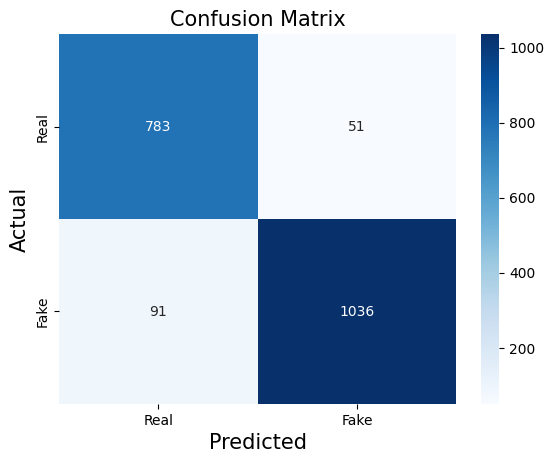

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(val_df_cv['label'].values, val_df_cv['preds'].values)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted", size=15)
plt.ylabel("Actual", size=15)
plt.title("Confusion Matrix", size=15)
plt.show()

### ROC AUC Curve

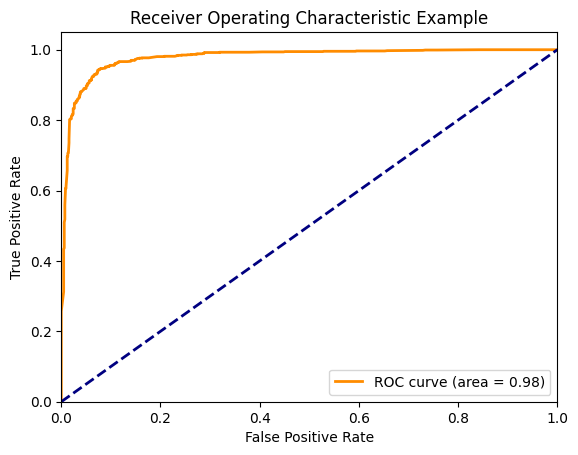

In [170]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val_list, y_preds_list)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()